## Deep Learning Model to mimic human behavior

In [1]:
import os
import numpy as np
import pandas as pd
from scipy.misc import imread
import matplotlib.pyplot as plt
from tqdm import tqdm, tqdm_notebook

from math import *
import cv2

import keras
from keras.models import Sequential, Model
from keras.layers import Dense, Activation, Input, InputLayer, Lambda, Flatten, Dropout
from keras.layers import Convolution2D, MaxPooling2D, Flatten, SpatialDropout2D, Cropping2D
from keras.applications.vgg16 import VGG16
from keras.preprocessing.image import load_img, img_to_array
from keras.preprocessing import image

from keras.optimizers import SGD, Adam, RMSprop
from keras.layers.normalization import BatchNormalization
from keras.models import model_from_json

import keras.backend as K

import matplotlib.image as mpimg
%matplotlib inline

Using TensorFlow backend.


#### Methods to generate batch of images

In [2]:
# Region of Interest
def roi(img):
    img = img[60:140,40:280]
    return cv2.resize(img, (200, 66))

# Generate batches of images
def image_generator(driving_log, data_path, normalizer=255.0, steering_shift=3.0, steering_max=25.):
    driving_log = driving_log.sample(frac=1).reset_index(drop=True)

    for index, row in driving_log.iterrows():
        fname  = os.path.basename(row['center'])
        fname1 = os.path.basename(row['left'])
        fname2 = os.path.basename(row['right'])
        
        img = load_img(data_path+'IMG/'+fname)
        img1 = load_img(data_path+'IMG/'+fname1)
        img2 = load_img(data_path+'IMG/'+fname2)
        
        img  = roi(cv2.cvtColor(img_to_array(img), cv2.COLOR_RGB2YUV))
        img1 = roi(cv2.cvtColor(img_to_array(img1), cv2.COLOR_RGB2YUV))
        img2 = roi(cv2.cvtColor(img_to_array(img2), cv2.COLOR_RGB2YUV))
        
        yield img, np.float32(row['steering'])
        yield img1, np.float32(row['steering'])+steering_shift/steering_max
        yield img2, np.float32(row['steering'])-steering_shift/steering_max
        
        
def batch_generator(driving_log, data_path, batch_size=32, *args, **kwargs):
    num_rows = len(driving_log.index)
    train_images = np.zeros((batch_size, img_rows, img_cols, 3))
    train_steering = np.zeros(batch_size)
    ctr = None
    while 1:        
        for j in range(batch_size):
            # Reset generator if over bounds
            if ctr is None or ctr >= num_rows:
                ctr = 0
                images = image_generator(driving_log, data_path, *args, **kwargs)
            train_images[j], train_steering[j] = next(images)
            ctr += 1
        yield train_images, train_steering

#### Data Visualization 

In [3]:
data_path = './data/'
img_rows, img_cols = 66, 200 # prepare data to adjust to NVIDIA end-to-end deep learning model

'''
import random

# Show some sample images and their labels
plt.figure(figsize=(20, 15))

for i in range(12):
    ind, image = random.choice(list(enumerate(X_train)))
    label_name = sign_dict[str(y_train[ind])]
    plt.subplot(4, 3, i+1)
    plt.imshow(image)
    plt.title(label_name)
    plt.axis('off')
plt.show()
'''

"\nimport random\n\n# Show some sample images and their labels\nplt.figure(figsize=(20, 15))\n\nfor i in range(12):\n    ind, image = random.choice(list(enumerate(X_train)))\n    label_name = sign_dict[str(y_train[ind])]\n    plt.subplot(4, 3, i+1)\n    plt.imshow(image)\n    plt.title(label_name)\n    plt.axis('off')\nplt.show()\n"

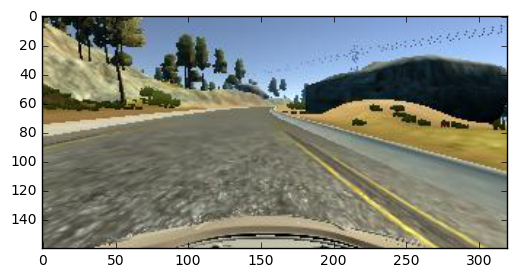

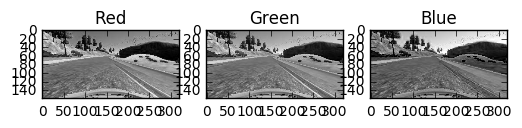

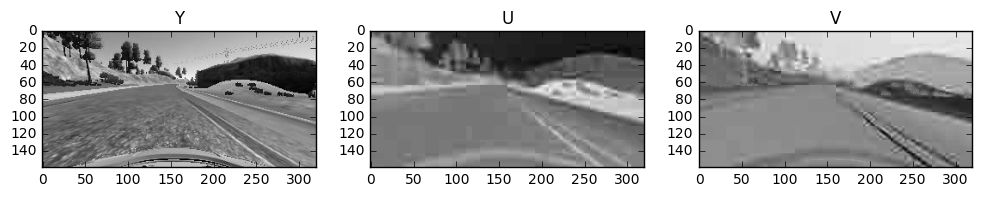

In [4]:
fname = 'center_2016_12_01_13_34_38_057.jpg'
im1 = mpimg.imread(data_path+'IMG/'+fname)

plt.figure()
plt.imshow(im1)
im = cv2.cvtColor(im1, cv2.COLOR_RGB2YUV)
# im = normalize_color(im)

plt.figure()
plt.rcParams['figure.figsize'] = (12,10)
plt.subplot(1,3,1)
plt.title('Red')
plt.imshow(im1[:,:,0]/255., cmap='gray')
plt.subplot(1,3,2)
plt.title('Green')
plt.imshow(im1[:,:,1]/255., cmap='gray')
plt.subplot(1,3,3)
plt.title('Blue')
plt.imshow(im1[:,:,2]/255., cmap='gray')
plt.show()

plt.figure()
plt.rcParams['figure.figsize'] = (12,10)
plt.subplot(1,3,1)
plt.title('Y')
plt.imshow(im[:,:,0]/255., cmap='gray')
plt.subplot(1,3,2)
plt.title('U')
plt.imshow(im[:,:,1]/255., cmap='gray')
plt.subplot(1,3,3)
plt.title('V')
plt.imshow(im[:,:,2]/255., cmap='gray')
plt.show()

#### Load Data

In [5]:
# load data from csv
columns = ['center', 'left', 'right', 'steering', 'throttle', 'brake', 'speed']
driving_log = pd.read_csv(data_path+'driving_log.csv', skiprows=1, names=columns) #skip header
driving_log = driving_log.sample(frac=1).reset_index(drop=True) # Shuffle the entire dataset

# split the dataset into train and validation set at roughly 90:10 ratio
driving_log_train = driving_log[:7200] #take the first 7200 rows
driving_log_validation = driving_log[7200:] # take the remaining for validation set

# generate batches of images 
train_data = batch_generator(driving_log_train, data_path, batch_size=32)
validation_data = batch_generator(driving_log_validation, data_path, batch_size=32)

# print count of train and validation sets
print(len(driving_log_train))
print(len(driving_log_validation))


7200
836


#### Network Architecture

In [6]:
# Model used: NVIDIA end-to-end deep learning for self driving cars
# https://arxiv.org/abs/1604.07316
# https://devblogs.nvidia.com/parallelforall/wp-content/uploads/2016/08/cnn-architecture.png
model = Sequential()
model.add(Lambda(lambda x: x/127.5 - 1., input_shape=(img_rows, img_cols, 3), name='Normalization'))  # Normalization courtesy of John Chen
model.add(Convolution2D(24, 5, 5, subsample=(2,2), activation='relu', name='Conv1'))
model.add(Convolution2D(36, 5, 5, subsample=(2,2), activation='relu', name='Conv2'))
model.add(Convolution2D(48, 5, 5, subsample=(2,2), activation='relu', name='Conv3'))
model.add(Convolution2D(64, 3, 3, activation='relu', name='Conv4'))
model.add(Convolution2D(64, 3, 3, activation='relu', name='Conv5'))
model.add(Flatten())
model.add(Dense(1164, activation='relu', name='FC1'))
model.add(Dropout(0.25))
model.add(Dense(100, activation='relu', name='FC2'))
model.add(Dropout(0.25))
model.add(Dense(50, activation='relu', name='FC3'))
model.add(Dropout(0.25))
model.add(Dense(10, activation='relu', name='FC4'))
model.add(Dense(1, name='output'))
model.summary()

____________________________________________________________________________________________________
Layer (type)                     Output Shape          Param #     Connected to                     
Normalization (Lambda)           (None, 66, 200, 3)    0           lambda_input_1[0][0]             
____________________________________________________________________________________________________
Conv1 (Convolution2D)            (None, 31, 98, 24)    1824        Normalization[0][0]              
____________________________________________________________________________________________________
Conv2 (Convolution2D)            (None, 14, 47, 36)    21636       Conv1[0][0]                      
____________________________________________________________________________________________________
Conv3 (Convolution2D)            (None, 5, 22, 48)     43248       Conv2[0][0]                      
___________________________________________________________________________________________

In [7]:
opt = Adam(lr=0.0001)
model.compile(optimizer=opt, loss='mse', metrics=[])

In [8]:
# class to store the loss history using keras callbacks
class LossHistory(keras.callbacks.Callback):
    def on_train_begin(self, logs={}):
        print('BEGIN TRAINING')
        self.losses = []

    def on_batch_end(self, batch, logs={}):
        self.losses.append(logs.get('loss'))

#### Model Training 

In [9]:
batch_history = LossHistory()

h = model.fit_generator(train_data, validation_data = validation_data,
                        samples_per_epoch = 28000,
                        nb_val_samples = 960,
                        nb_epoch=2, verbose=1, callbacks=[batch_history])

BEGIN TRAINING
Epoch 1/2
28000/28000 [==============================] - 217s - loss: 0.0168 - val_loss: 0.0118
Epoch 2/2
28000/28000 [==============================] - 208s - loss: 0.0133 - val_loss: 0.0142


In [10]:
# save model as json file
# save model weights as h5 file
from pathlib import Path
import json

json_string = model.to_json()
with open('model.json','w' ) as f:
    json.dump(json_string, f)
model.save_weights('model.h5')